In [2]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
pd.plotting.register_matplotlib_converters()
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm
from xgboost import XGBRegressor

## Preparing samples

In [4]:
data = pd.read_csv("CUP_IT_train_data.csv")

In [6]:
data['dlk_cob_date'] = pd.to_datetime(data['dlk_cob_date'])

In [7]:
s = (data.dtypes == 'object')
object_cols = list(s[s].index)

# Make copy to avoid changing original data 
label_X_train = data.copy()

# Apply label encoder to each column with categorical data
label_encoder = LabelEncoder()
for col in object_cols:
    data[col] = data[col].apply(str)
    label_X_train[col] = label_encoder.fit_transform(data[col])

In [9]:
label_X_train

,cif_id,dlk_cob_date,gi_smooth_3m,big_city,cu_gender,cu_education_level,cu_empl_area,cu_empl_level,payroll_f,cur_quantity_pl,...,active,standalone_dc_f,standalone_payroll_dc_f,standalone_nonpayroll_dc_f,salary,cu_age,cu_mob,cu_empl_cur_dur_m,is_married,cu_eduaction_level
0,335992,2018-06-30,17.957530,0,0,1,63,18,0,1,...,1,0,0,0,1192.8,29.0,144,46.0,1,2
1,335992,2018-04-30,27.720918,0,0,1,63,18,0,1,...,1,0,0,0,1192.8,29.0,142,44.0,1,2
2,335992,2018-05-31,21.949626,0,0,1,63,18,0,1,...,1,0,0,0,1192.8,29.0,143,45.0,1,2
3,335992,2018-08-31,14.855459,0,0,1,63,18,0,1,...,1,0,0,0,1192.8,29.0,146,48.0,1,2
4,335992,2018-03-31,27.917161,0,0,1,63,18,0,1,...,1,0,0,0,1192.8,29.0,141,43.0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4161778,120605,2018-06-30,52.379263,1,0,1,63,18,0,1,...,1,1,0,1,960.0,34.0,115,31.0,1,2
4161779,120605,2018-02-28,54.218822,1,0,1,63,18,0,1,...,1,1,0,1,960.0,33.0,111,27.0,1,2
4161780,120605,2018-03-31,53.343644,1,0,1,63,18,0,1,...,1,1,0,1,960.0,33.0,112,28.0,1,2
4161781,120605,2018-04-30,52.248182,1,0,1,63,18,0,1,...,1,1,0,1,960.0,34.0,113,29.0,1,2


In [10]:
# Imputation
my_imputer = SimpleImputer()
imputed_X_train = pd.DataFrame(my_imputer.fit_transform(label_X_train.drop(columns=['dlk_cob_date'])))

# Imputation removed column names; put them back
imputed_X_train.insert(1, 'dlk_cob_date', label_X_train['dlk_cob_date'])
imputed_X_train.columns = label_X_train.columns

In [11]:
imputed_X_train.iloc[:140,10:20]

,cur_quantity_mort,cur_quantity_cc,cur_quantity_deposits,cur_quantity_dc,cur_quantity_accounts,cur_quantity_saccounts,cur_quantity_mf,cc_balance,cl_balance,ml_balance
0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,-1042.465432,-2996.8384,-37766.93951
1,0.0,0.0,0.0,1.0,1.0,0.0,0.0,-1042.465432,-2996.8384,-37766.93951
2,0.0,0.0,0.0,1.0,1.0,0.0,0.0,-1042.465432,-2996.8384,-37766.93951
3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,-1042.465432,-2996.8384,-37766.93951
4,0.0,0.0,0.0,1.0,1.0,0.0,0.0,-1042.465432,-2996.8384,-37766.93951
...,...,...,...,...,...,...,...,...,...,...
135,0.0,2.0,0.0,0.0,1.0,0.0,0.0,-1275.138480,-2996.8384,-37766.93951
136,0.0,2.0,0.0,0.0,1.0,0.0,0.0,-1287.708240,-2996.8384,-37766.93951
137,0.0,2.0,0.0,0.0,1.0,0.0,0.0,-1151.651040,-2996.8384,-37766.93951
138,0.0,2.0,0.0,0.0,1.0,0.0,0.0,-1236.267120,-2996.8384,-37766.93951


In [13]:
users_id = data['cif_id'].unique()[:6000]
size = 44
X_users = np.ndarray(shape=(0, size))
y_users = np.empty(0)
for j in tqdm(np.arange(len(users_id))):
    user = users_id[j]
    current_user_data = imputed_X_train[imputed_X_train.cif_id == user].sort_values(by='dlk_cob_date').drop(columns=['dlk_cob_date', 'gi_smooth_3m']).to_numpy()
    gi_smooth_3m = imputed_X_train[imputed_X_train.cif_id == user].sort_values(by='dlk_cob_date')['gi_smooth_3m'].to_numpy()
    for i in np.arange(len(current_user_data) - 6):
        X_users = np.append(X_users, current_user_data[i].reshape((1, size)), axis=0)
        y_users = np.append(y_users, np.asarray([sum(gi_smooth_3m[i + 1:i + 8])]), axis=0)

100%|██████████| 6000/6000 [03:06<00:00, 32.23it/s]


In [14]:
X_users.shape

(29181, 44)

### Saving

In [15]:
np.savez_compressed('data_np', sample=X_users, label=y_users)

### Loading

In [2]:
tmp = np.load('data_np.npz')
X_users = tmp['sample']
y_users = tmp['label']
X_users.shape

(14699, 44)

## Predicting

#### XGBoost

In [17]:
X = pd.DataFrame(X_users, columns=data.drop(columns=['dlk_cob_date', 'gi_smooth_3m']).columns)
y = pd.DataFrame(y_users, columns=['gi_smooth_3m'])

In [18]:
print(X.shape)
print(y.shape)

(29181, 44)
(29181, 1)


In [31]:
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)
X_train = X_train_full.copy()
X_valid = X_valid_full.copy()
X_test = X_valid_full.copy() # TODO: replace with data from separate file

In [32]:
my_model = XGBRegressor(n_estimators=200)
my_model.fit(X_train, y_train, 
             early_stopping_rounds=7, 
             eval_set=[(X_valid, y_valid)],
             verbose=False)
# Get predictions
predictions_1 = my_model.predict(X_valid) # Your code here

[23:48:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [33]:
print(predictions_1, "\n", y_valid)
# # Calculate MAE
# mae_1 = mean_absolute_error(predictions_1, prev) # Your code here
# prev = predictions_1
# # Uncomment to print MAE
# print("Mean Absolute Error:" , mae_1)

[457.17288  177.7934    30.083574 ... 219.98894  136.5852   171.62608 ] 
        gi_smooth_3m
22048    526.731264
2143     529.589714
20933      1.128726
25070    240.675222
22172      0.703349
...             ...
21977     20.283964
14795     14.025841
12847    270.823205
15062    223.619260
20163     62.231357

[5837 rows x 1 columns]


(100, 2)


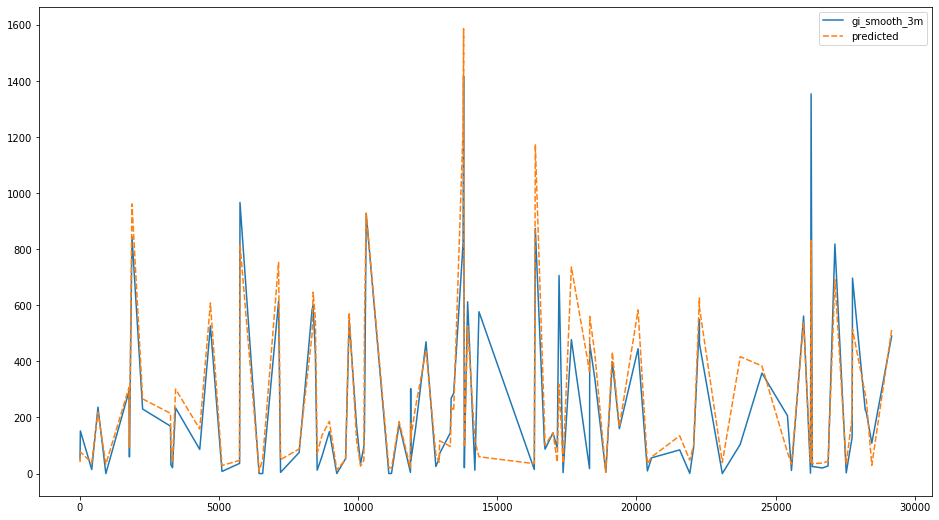

In [34]:
# Set the width and height of the figure
plt.figure(figsize=(16,9))
tmp = y_valid.copy()
tmp['predicted'] = predictions_1
tmp = tmp.iloc[500:600, :]
print(tmp.shape)
# Line chart showing how FIFA rankings evolved over time 
sns.lineplot(data=tmp)

(100, 2)


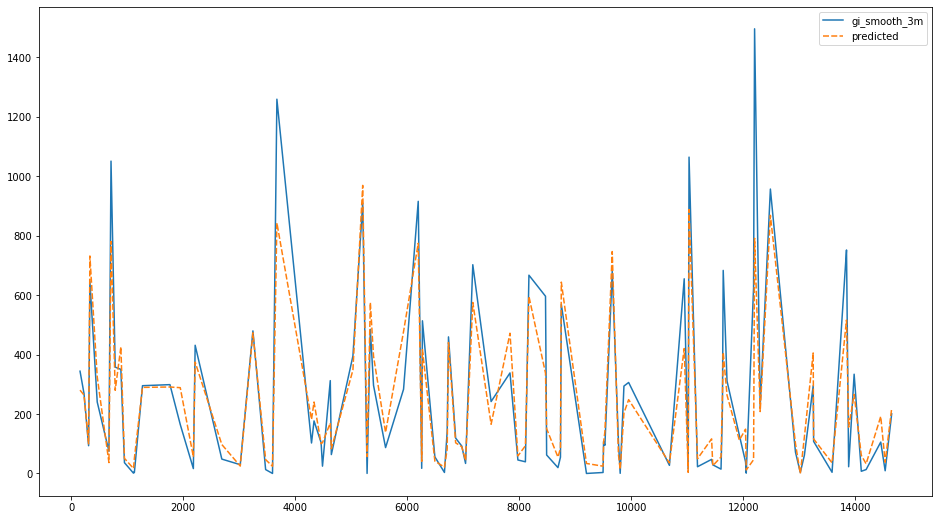

In [114]:
# Set the width and height of the figure
plt.figure(figsize=(16,9))
tmp = y_valid.copy()
tmp['predicted'] = predictions_1
tmp = tmp.iloc[500:600, :]
print(tmp.shape)
# Line chart showing how FIFA rankings evolved over time 
sns.lineplot(data=tmp)